In [170]:
import sys
nb_out = sys.stdout
import tsaugmentation as tsag
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sys.stdout = nb_out

In [2]:
import mindarmour

In [3]:
data = tsag.preprocessing.PreprocessDatasets('tourism').apply_preprocess()

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [90]:
dataset = data['train']['data']

# Concept Drift check time series

### Parameters

In [526]:
window_size = 24   # window_size(int): Size of a concept window, no less than 10. If given the input data,
                    # window_size belongs to [10, 1/3*len(input data)]. If the data is periodic, usually
                    # window_size equals 2-5 periods, such as, for monthly/weekly data, the data volume
                    # of 30/7 days is a period. Default: 100.
rolling_window = 3 # rolling_window(int): Smoothing window size, belongs to [1, window_size]. Default:10.
step = 10           # step(int): The jump length of the sliding window, belongs to [1, window_size]. Default:10

res_size = 50
in_size = window_size
out_size = window_size

### Preprocess data

In [527]:
def data_preprocess(data, rolling_window):
    data_av = np.zeros((data.shape[0]-rolling_window + 1, data.shape[1]))
    # Moving average
    for i in range(data.shape[1]):
        data_av[:,i] = np.convolve(data[:, i],
                             np.ones((rolling_window,)) / rolling_window, 'valid')
        
    return data_av

In [528]:
dataset = data['train']['data']

In [529]:
data_av = data_preprocess(dataset, rolling_window)

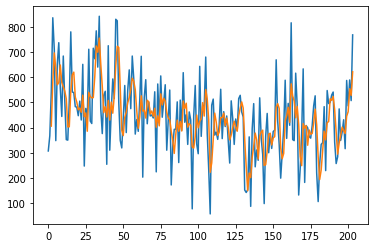

In [530]:
plt.plot(dataset[:,0])
plt.plot(np.arange(rolling_window - 1, data['train']['data'][:,0].shape[0]), data_av[:,0]);

In [531]:
data_av = np.concatenate((data_av, data_av[-(rolling_window-1):]), axis=0)
data_av = (data_av - data_av.min(axis=0)) / (data_av.max(axis=0) - data_av.min(axis=0))

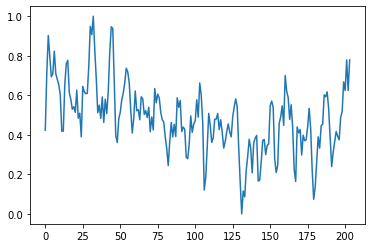

In [532]:
plt.plot(np.arange(data_av[:,0].shape[0]), data_av[:,0]);

### Calculate drift score

In [729]:
def w_generate(res_size, in_size, input_data):
    """
    Randomly generate weights of the reservoir model.
    Args:
        res_size(int): The number of reservoir nodes.
        in_size(int): The input size of reservoir model.
        input_data(numpy.ndarray): Input data.
    Returns:
        - numpy.ndarray, the state of reservoir.
    """
    # Weight generates randomly
    np.random.seed(42)
    w_in = np.random.rand(res_size, in_size) - 0.5
    w_0 = np.random.rand(res_size, res_size) - 0.5
    w_0 *= 0.8
    a_speed = 0.3
    
    # Reservoir state
    x_state = np.zeros((res_size, input_data.shape[1]))
    for _ in range(50):
        x_state = (1 - a_speed)*x_state + \
                  a_speed*np.tanh(np.dot(w_in, input_data) + np.dot(w_0, x_state))
    return x_state

In [ ]:
def feature_extraction(window_data):
    # Initialize weights
    x_state = w_generate(res_size, in_size, window_data)
    x_state_t = x_state.T
    
    reg = 1e-8
    
    # Calculate w_out
    w_out = np.dot(np.dot(window_data, x_state_t),
                   np.linalg.inv(np.dot(x_state, x_state_t) + reg*np.eye(res_size)))
    
    return w_out, x_state

In [814]:
def concept_distance(data_x, data_y):
    """
    Calculate the distance of two example blocks.
    Args:
        data_x(numpy.ndarray): Data x.
        data_y(numpy.ndarray): Data y.
    Returns:
        - float, distance between data_x and data_y.
    Examples:
        >>> x = np.random.rand(100)
        >>> y = np.random.rand(100)
        >>> score = ConceptDriftCheckTimeSeries._concept_distance(x, y)
    """
    # Feature extraction
    feature_x = feature_extraction(data_x)
    feature_y = feature_extraction(data_y)
    # Calculate distance
    distance_wx = np.sum(abs(np.dot(feature_x[0], feature_x[1])
                          - np.dot(feature_y[0], feature_y[1])), axis=0)/len(data_x)
    statistic_feature = abs(data_x.mean(axis=0) - data_y.mean(axis=0))
    distance_score = (distance_wx + statistic_feature) / (1 + distance_wx + statistic_feature)
    distance_score_mean = distance_score.mean(axis=0)
    return distance_score_mean

In [819]:
data_x = data_av[i: i + window_size]
data_y = data_av[i + window_size:i + 2*window_size]

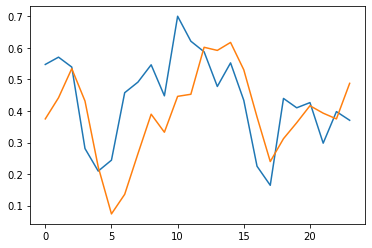

In [785]:
plt.plot(data_x[:,0])
plt.plot(data_y[:,0]);

In [786]:
data_x_features = feature_extraction(data_x)
data_y_features = feature_extraction(data_y)

In [787]:
data_x_features[0].shape

(24, 50)

In [788]:
data_x_features[1].shape

(50, 304)

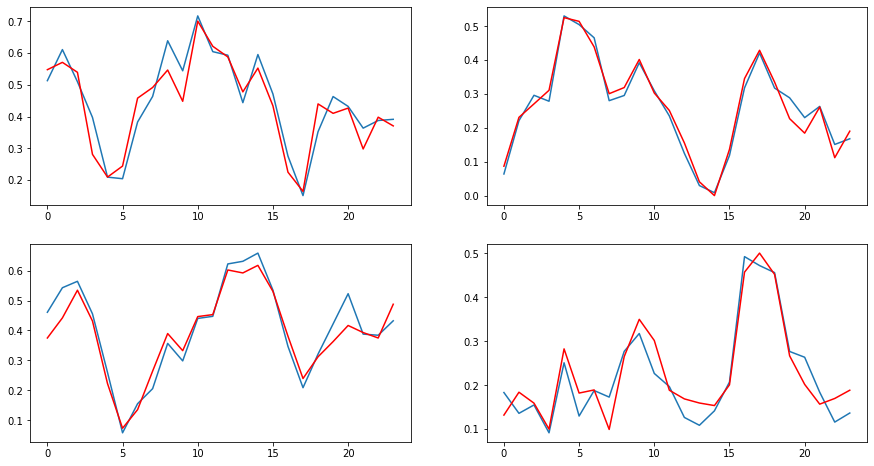

In [789]:
_, ax = plt.subplots(2, 2, figsize=(15, 8))

ax = ax.ravel()

ax[0].plot(np.dot(data_x_features[0], data_x_features[1])[:,0])
ax[0].plot(data_x[:,0], color='r');

ax[1].plot(np.dot(data_x_features[0], data_x_features[1])[:,1])
ax[1].plot(data_x[:,1], color='r');

ax[2].plot(np.dot(data_y_features[0], data_y_features[1])[:,0])
ax[2].plot(data_y[:,0], color='r');

ax[3].plot(np.dot(data_y_features[0], data_y_features[1])[:,1])
ax[3].plot(data_y[:,1], color='r');

In the reservoir model there are trained weights `w_out` and non-trained `x_state`. Notice that multiplying `w_out` and `x_state` gets us closed to the true time series. Seems that the `x_state` is what defines how close you would be for a time series. 

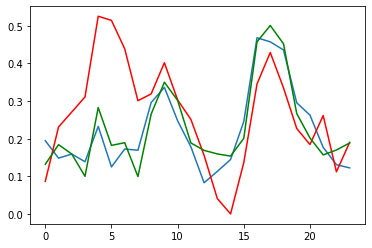

In [790]:
plt.plot(np.dot(data_x_features[0], data_y_features[1])[:,1])
plt.plot(data_x[:,1], color='r');
plt.plot(data_y[:,1], color='g');

This happens because the encoding is happening at the `x_state` for each time series window and `w_out` is very similar between time series (at least for similar time series).

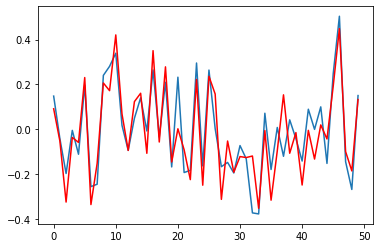

In [791]:
plt.plot(data_x_features[0][0,:])
plt.plot(data_y_features[0][0,:], color='r');

In [822]:
drift_score = np.zeros((dataset.shape[0], dataset.shape[1]))

for i in range(0, dataset.shape[0] - 2*window_size, step):
    data_x = data_av[i: i + window_size]
    data_y = data_av[i + window_size:i + 2*window_size]
    drift_score[i + window_size,:] = concept_distance(data_x, data_y)

In [149]:
concept = mindarmour.ConceptDriftCheckTimeSeries(window_size=24, rolling_window=10, step=10, threshold_index=2.5,need_label=False)

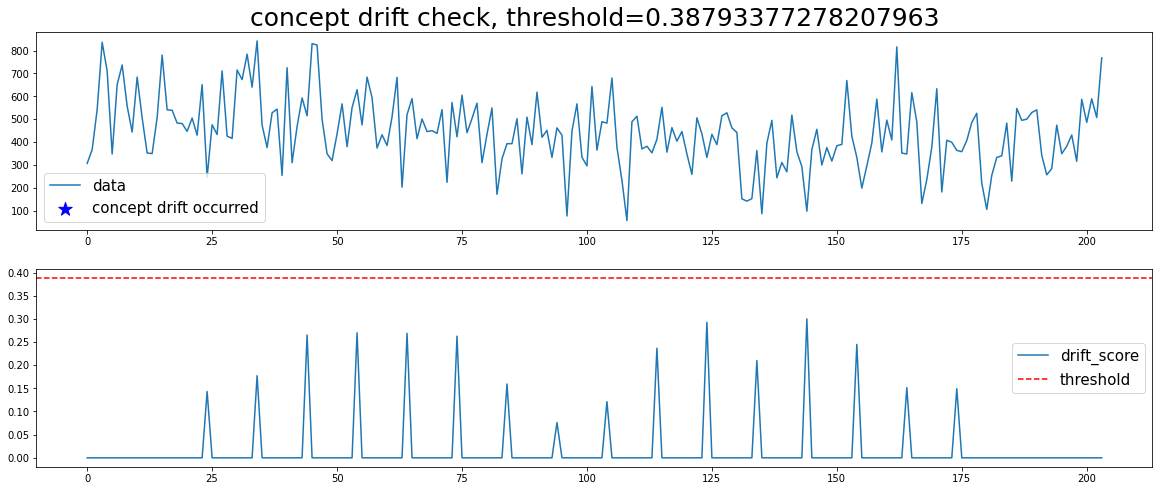

In [82]:
drift_score, threshold, concept_drift_location = concept.concept_check(dataset)